In [1]:
import os
import random
import time
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE
from ptflops import get_model_complexity_info
import optuna
from tqdm import tqdm
import timm

# Data paths based on the provided file structure
BASE_DIR = '/home/du/sakib_rme/Sugarcane_Leaf_Diseaes_Classification/Dataset'
TRAIN_SET_DIR = os.path.join(BASE_DIR, 'Train_set')
AUG_SET_DIR = os.path.join(BASE_DIR, 'Augmented_Set')
TEST_SET_DIR = os.path.join(BASE_DIR, 'Test_set')

# Model & Training Parameters
RANDOM_STATE = 42
IMG_SIZE = 256
CROP_SIZE = 224
BATCH_SIZE = 32
N_OPTUNA_TRIALS = 20  
OPTUNA_EPOCHS = 25     
FULL_TRAIN_EPOCHS = 100
EARLY_STOPPING_PATIENCE = 10 

# Set random seeds for reproducibility
torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
os.makedirs('./mobilenetv3_small_outputs', exist_ok=True)

# --- 2. Data Loading and Preparation ---
def load_image_paths(directories):
    """Loads image paths and labels from a list of directories."""
    all_paths = []
    all_labels = []
    class_names = sorted([d for d in os.listdir(directories[0]) if os.path.isdir(os.path.join(directories[0], d))])
    class_to_int = {name: i for i, name in enumerate(class_names)}
    int_to_class = {i: name for i, name in enumerate(class_names)}

    for directory in directories:
        for class_name in class_names:
            class_dir = os.path.join(directory, class_name)
            if not os.path.isdir(class_dir):
                continue
            image_files = [os.path.join(class_dir, fname) for fname in os.listdir(class_dir) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]
            all_paths.extend(image_files)
            all_labels.extend([class_to_int[class_name]] * len(image_files))
    return all_paths, all_labels, class_to_int, int_to_class

print("--- Loading Data ---")
# Combine original train and augmented sets for the training pool
train_val_paths, train_val_labels, class_to_int, int_to_class = load_image_paths([TRAIN_SET_DIR, AUG_SET_DIR])
test_paths, test_labels, _, _ = load_image_paths([TEST_SET_DIR])
num_classes = len(class_to_int)

print(f"Found {num_classes} classes: {list(class_to_int.keys())}")

# Stratified split for train and validation
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths, train_val_labels, test_size=0.2, stratify=train_val_labels, random_state=RANDOM_STATE
)

print(f"Total training pool images: {len(train_val_paths)}")
print(f"Training samples: {len(train_paths)}")
print(f"Validation samples: {len(val_paths)}")
print(f"Test samples: {len(test_paths)}")

class SugarcaneLeafDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)
        
# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.CenterCrop(CROP_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = SugarcaneLeafDataset(train_paths, train_labels, transform=train_transform)
val_dataset = SugarcaneLeafDataset(val_paths, val_labels, transform=val_test_transform)
test_dataset = SugarcaneLeafDataset(test_paths, test_labels, transform=val_test_transform)

# Handle class imbalance for training loader with WeightedRandomSampler
class_counts = np.bincount(train_labels)
class_weights = 1. / class_counts
sample_weights = np.array([class_weights[label] for label in train_labels])
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# --- 3. Model Definition (MobileNetV3-Small with Timm) ---
class RegularizedMobileNetV3Small(nn.Module):

    def __init__(self, num_classes, dropout_rate1=0.5, dropout_rate2=0.5, freeze_ratio=0.5):
        super().__init__()
        self.timm_model_name = 'mobilenetv3_small_100'
        
        # Load the base model from timm with pretrained weights.
        self.base_model = timm.create_model(self.timm_model_name, pretrained=True, num_classes=0)
        print(f"Loaded '{self.timm_model_name}' from timm with pretrained weights.")

        # Freeze layers based on the freeze_ratio
        all_params = list(self.base_model.parameters())
        num_to_freeze = int(len(all_params) * freeze_ratio)
        if num_to_freeze > 0:
            print(f"Freezing the first {num_to_freeze} of {len(all_params)} parameter groups.")
            for i, param in enumerate(all_params):
                if i < num_to_freeze:
                    param.requires_grad = False
        
        # --- THIS IS THE FIX ---
        # Get the number of input features for the classifier from the `conv_head` layer.
        # `self.base_model.num_features` is incorrect for this specific architecture.
        in_features = self.base_model.conv_head.out_channels
        print(f"Correctly identified base model feature dimension: {in_features}")
        
        # Replace the model's classifier with a new custom head
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate1),
            nn.Linear(in_features, 1024),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(1024),
            nn.Dropout(p=dropout_rate2),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)

# --- 4. Training & Evaluation Functions ---
def train_epoch(model, loader, criterion, optimizer, device, grad_clip_norm=1.0):
    model.train()
    running_loss = 0.0
    for data, targets in loader:
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip_norm)
        optimizer.step()
        running_loss += loss.item() * data.size(0)
    return running_loss / len(loader.dataset)

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds, all_targets, all_outputs = [], [], []
    with torch.no_grad():
        for data, targets in loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * data.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            all_outputs.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    loss = running_loss / len(loader.dataset)
    accuracy = 100 * np.sum(np.array(all_preds) == np.array(all_targets)) / len(all_targets)
    return loss, accuracy, all_preds, all_targets, np.array(all_outputs)
    
# --- 5. Hyperparameter Tuning with Optuna ---
def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["AdamW", "Adam"])
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    dropout_rate1 = trial.suggest_float("dropout_rate1", 0.1, 0.6)
    dropout_rate2 = trial.suggest_float("dropout_rate2", 0.1, 0.6)
    freeze_ratio = trial.suggest_float("freeze_ratio", 0.0, 0.8)
    label_smoothing = trial.suggest_float("label_smoothing", 0.0, 0.2)
    grad_clip = trial.suggest_float("grad_clip", 0.5, 2.0)

    # Model, Optimizer, Criterion
    model = RegularizedMobileNetV3Small(num_classes, dropout_rate1, dropout_rate2, freeze_ratio).to(device)
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

    # Training loop for the trial
    for epoch in range(OPTUNA_EPOCHS):
        train_epoch(model, train_loader, criterion, optimizer, device, grad_clip)
        val_loss, val_acc, _, _, _ = evaluate(model, val_loader, criterion, device)
        
        print(f"Trial {trial.number} | Epoch {epoch+1}/{OPTUNA_EPOCHS} | Val Acc: {val_acc:.2f}%")
        trial.report(val_acc, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_acc
    
print("\n--- Starting Hyperparameter Optimization with Optuna ---")
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=N_OPTUNA_TRIALS) 

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
best_trial = study.best_trial
print(f"  Value: {best_trial.value:.2f}%")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")
best_hyperparams = best_trial.params

# --- 6. Final Model Training ---
print("\n--- Starting Final Training with Best Hyperparameters ---")
final_model = RegularizedMobileNetV3Small(
    num_classes=num_classes,
    dropout_rate1=best_hyperparams["dropout_rate1"],
    dropout_rate2=best_hyperparams["dropout_rate2"],
    freeze_ratio=best_hyperparams["freeze_ratio"]
).to(device)

final_optimizer = getattr(torch.optim, best_hyperparams["optimizer"])(
    final_model.parameters(), lr=best_hyperparams["lr"], weight_decay=best_hyperparams["weight_decay"]
)
final_criterion = nn.CrossEntropyLoss(label_smoothing=best_hyperparams["label_smoothing"])
final_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(final_optimizer, T_max=FULL_TRAIN_EPOCHS)

# Calculate and print model complexity
try:
    macs, params = get_model_complexity_info(final_model, (3, CROP_SIZE, CROP_SIZE), as_strings=True, print_per_layer_stat=False, verbose=False)
    print(f"\nFinal Model Complexity: MACs: {macs}, Params: {params}")
except Exception as e:
    print(f"Could not calculate model complexity: {e}")
    
# Training loop with early stopping
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_loss = float('inf')
epochs_no_improve = 0
training_start_time = time.time()

for epoch in range(FULL_TRAIN_EPOCHS):
    train_loss = train_epoch(final_model, train_loader, final_criterion, final_optimizer, device, best_hyperparams["grad_clip"])
    _, train_acc, _, _, _ = evaluate(final_model, train_loader, final_criterion, device)
    val_loss, val_acc, _, _, _ = evaluate(final_model, val_loader, final_criterion, device)
    
    final_scheduler.step()
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f'Epoch {epoch+1}/{FULL_TRAIN_EPOCHS} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(final_model.state_dict(), './mobilenetv3_small_outputs/best_model.pth')
        print("  Validation loss decreased. Model saved.")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
        print(f"\nEarly stopping triggered after {epoch + 1} epochs.")
        break

total_training_duration = time.time() - training_start_time
print(f"Total final training time: {total_training_duration/60:.2f} minutes.")

# --- 7. Final Evaluation and Visualization ---
# (This part of the code remains unchanged but will now run with the corrected model)
print("\n--- Final Evaluation on Test Set ---")
best_model = RegularizedMobileNetV3Small(
    num_classes=num_classes,
    dropout_rate1=best_hyperparams["dropout_rate1"],
    dropout_rate2=best_hyperparams["dropout_rate2"],
    freeze_ratio=best_hyperparams["freeze_ratio"]
).to(device)
best_model.load_state_dict(torch.load('./mobilenetv3_small_outputs/best_model.pth', map_location=device))

inference_start_time = time.time()
test_loss, test_acc, test_preds, test_targets, test_outputs = evaluate(best_model, test_loader, final_criterion, device)
inference_duration = time.time() - inference_start_time
avg_inference_time = (inference_duration / len(test_dataset)) * 1000

print(f"Test Set Performance: Loss: {test_loss:.4f}, Accuracy: {test_acc:.2f}%")
print(f"Average inference time per image: {avg_inference_time:.2f} ms")

[I 2025-07-18 03:36:02,462] A new study created in memory with name: no-name-9d012635-54ad-4ee6-824d-82f7ba9ac4e1


Using device: cuda
--- Loading Data ---
Found 17 classes: ['Banded_Chlorosis', 'Brown_Rust', 'Brown_Spot', 'Dried_Leaves', 'Eye_Spot', 'Grassy_Shoot', 'Healthy', 'Mosaic', 'Pokkah_Boeng', 'RedRot', 'Red_Leaf_Spot', 'Ring_Spot', 'Rust', 'Sett_Rot', 'Smut', 'Viral_Disease', 'Yellow_Leaf']
Total training pool images: 11314
Training samples: 9051
Validation samples: 2263
Test samples: 1414

--- Starting Hyperparameter Optimization with Optuna ---
Loaded 'mobilenetv3_small_100' from timm with pretrained weights.
Freezing the first 57 of 140 parameter groups.
Correctly identified base model feature dimension: 1024
Trial 0 | Epoch 1/25 | Val Acc: 34.95%
Trial 0 | Epoch 2/25 | Val Acc: 53.56%
Trial 0 | Epoch 3/25 | Val Acc: 57.58%
Trial 0 | Epoch 4/25 | Val Acc: 48.83%
Trial 0 | Epoch 5/25 | Val Acc: 55.90%
Trial 0 | Epoch 6/25 | Val Acc: 50.86%
Trial 0 | Epoch 7/25 | Val Acc: 53.95%
Trial 0 | Epoch 8/25 | Val Acc: 50.99%
Trial 0 | Epoch 9/25 | Val Acc: 47.81%
Trial 0 | Epoch 10/25 | Val Acc: 

[I 2025-07-18 04:01:27,023] Trial 0 finished with value: 62.74856385329209 and parameters: {'lr': 0.0033460105464994676, 'optimizer': 'Adam', 'weight_decay': 0.007470503276383016, 'dropout_rate1': 0.20667503361909254, 'dropout_rate2': 0.3230279484239129, 'freeze_ratio': 0.4092896080140265, 'label_smoothing': 0.04450200801663602, 'grad_clip': 1.4483133506555887}. Best is trial 0 with value: 62.74856385329209.


Trial 0 | Epoch 25/25 | Val Acc: 62.75%
Loaded 'mobilenetv3_small_100' from timm with pretrained weights.
Freezing the first 76 of 140 parameter groups.
Correctly identified base model feature dimension: 1024
Trial 1 | Epoch 1/25 | Val Acc: 41.89%
Trial 1 | Epoch 2/25 | Val Acc: 67.48%
Trial 1 | Epoch 3/25 | Val Acc: 76.93%
Trial 1 | Epoch 4/25 | Val Acc: 75.56%
Trial 1 | Epoch 5/25 | Val Acc: 85.20%
Trial 1 | Epoch 6/25 | Val Acc: 84.22%
Trial 1 | Epoch 7/25 | Val Acc: 86.65%
Trial 1 | Epoch 8/25 | Val Acc: 88.82%
Trial 1 | Epoch 9/25 | Val Acc: 88.60%
Trial 1 | Epoch 10/25 | Val Acc: 89.00%
Trial 1 | Epoch 11/25 | Val Acc: 91.60%
Trial 1 | Epoch 12/25 | Val Acc: 91.34%
Trial 1 | Epoch 13/25 | Val Acc: 90.94%
Trial 1 | Epoch 14/25 | Val Acc: 92.05%
Trial 1 | Epoch 15/25 | Val Acc: 93.73%
Trial 1 | Epoch 16/25 | Val Acc: 92.31%
Trial 1 | Epoch 17/25 | Val Acc: 91.69%
Trial 1 | Epoch 18/25 | Val Acc: 93.28%
Trial 1 | Epoch 19/25 | Val Acc: 91.96%
Trial 1 | Epoch 20/25 | Val Acc: 93.55%


[I 2025-07-18 04:30:42,973] Trial 1 finished with value: 90.14582412726469 and parameters: {'lr': 0.004834381174867773, 'optimizer': 'AdamW', 'weight_decay': 1.149723213000458e-05, 'dropout_rate1': 0.5422723630068361, 'dropout_rate2': 0.23022546288177817, 'freeze_ratio': 0.5445577385900592, 'label_smoothing': 0.06727313162197415, 'grad_clip': 1.62335265924589}. Best is trial 1 with value: 90.14582412726469.


Trial 1 | Epoch 25/25 | Val Acc: 90.15%
Loaded 'mobilenetv3_small_100' from timm with pretrained weights.
Freezing the first 12 of 140 parameter groups.
Correctly identified base model feature dimension: 1024
Trial 2 | Epoch 1/25 | Val Acc: 77.29%
Trial 2 | Epoch 2/25 | Val Acc: 84.62%
Trial 2 | Epoch 3/25 | Val Acc: 91.96%
Trial 2 | Epoch 4/25 | Val Acc: 93.59%
Trial 2 | Epoch 5/25 | Val Acc: 92.93%
Trial 2 | Epoch 6/25 | Val Acc: 92.13%
Trial 2 | Epoch 7/25 | Val Acc: 93.86%
Trial 2 | Epoch 8/25 | Val Acc: 95.18%
Trial 2 | Epoch 9/25 | Val Acc: 93.95%
Trial 2 | Epoch 10/25 | Val Acc: 92.40%
Trial 2 | Epoch 11/25 | Val Acc: 94.12%
Trial 2 | Epoch 12/25 | Val Acc: 94.12%
Trial 2 | Epoch 13/25 | Val Acc: 92.09%
Trial 2 | Epoch 14/25 | Val Acc: 94.30%
Trial 2 | Epoch 15/25 | Val Acc: 94.79%
Trial 2 | Epoch 16/25 | Val Acc: 95.54%
Trial 2 | Epoch 17/25 | Val Acc: 95.89%
Trial 2 | Epoch 18/25 | Val Acc: 94.92%
Trial 2 | Epoch 19/25 | Val Acc: 95.05%
Trial 2 | Epoch 20/25 | Val Acc: 95.63%


[I 2025-07-18 05:00:24,693] Trial 2 finished with value: 93.85771100309324 and parameters: {'lr': 0.0004628309601695446, 'optimizer': 'Adam', 'weight_decay': 1.1250704045604213e-05, 'dropout_rate1': 0.4250177199038788, 'dropout_rate2': 0.4875337381642002, 'freeze_ratio': 0.08668210246899638, 'label_smoothing': 0.14731619531380544, 'grad_clip': 1.203120884592249}. Best is trial 2 with value: 93.85771100309324.


Trial 2 | Epoch 25/25 | Val Acc: 93.86%
Loaded 'mobilenetv3_small_100' from timm with pretrained weights.
Freezing the first 15 of 140 parameter groups.
Correctly identified base model feature dimension: 1024
Trial 3 | Epoch 1/25 | Val Acc: 79.01%
Trial 3 | Epoch 2/25 | Val Acc: 81.97%
Trial 3 | Epoch 3/25 | Val Acc: 81.48%
Trial 3 | Epoch 4/25 | Val Acc: 83.25%
Trial 3 | Epoch 5/25 | Val Acc: 82.24%
Trial 3 | Epoch 6/25 | Val Acc: 81.53%
Trial 3 | Epoch 7/25 | Val Acc: 81.93%
Trial 3 | Epoch 8/25 | Val Acc: 83.16%
Trial 3 | Epoch 9/25 | Val Acc: 84.18%
Trial 3 | Epoch 10/25 | Val Acc: 80.82%
Trial 3 | Epoch 11/25 | Val Acc: 71.54%
Trial 3 | Epoch 12/25 | Val Acc: 84.18%
Trial 3 | Epoch 13/25 | Val Acc: 81.71%
Trial 3 | Epoch 14/25 | Val Acc: 82.50%
Trial 3 | Epoch 15/25 | Val Acc: 82.19%
Trial 3 | Epoch 16/25 | Val Acc: 85.90%
Trial 3 | Epoch 17/25 | Val Acc: 79.98%
Trial 3 | Epoch 18/25 | Val Acc: 85.15%
Trial 3 | Epoch 19/25 | Val Acc: 84.45%
Trial 3 | Epoch 20/25 | Val Acc: 83.56%


[I 2025-07-18 05:29:21,046] Trial 3 finished with value: 76.97746354396818 and parameters: {'lr': 0.0005257369587227037, 'optimizer': 'Adam', 'weight_decay': 0.0032681474063559835, 'dropout_rate1': 0.5812878661468619, 'dropout_rate2': 0.28204721519265175, 'freeze_ratio': 0.11397602339529166, 'label_smoothing': 0.1553178317742728, 'grad_clip': 1.9168277487564778}. Best is trial 2 with value: 93.85771100309324.


Trial 3 | Epoch 25/25 | Val Acc: 76.98%
Loaded 'mobilenetv3_small_100' from timm with pretrained weights.
Freezing the first 32 of 140 parameter groups.
Correctly identified base model feature dimension: 1024
Trial 4 | Epoch 1/25 | Val Acc: 81.09%
Trial 4 | Epoch 2/25 | Val Acc: 84.22%
Trial 4 | Epoch 3/25 | Val Acc: 79.50%
Trial 4 | Epoch 4/25 | Val Acc: 81.22%
Trial 4 | Epoch 5/25 | Val Acc: 84.27%
Trial 4 | Epoch 6/25 | Val Acc: 82.90%
Trial 4 | Epoch 7/25 | Val Acc: 81.22%
Trial 4 | Epoch 8/25 | Val Acc: 82.19%
Trial 4 | Epoch 9/25 | Val Acc: 83.25%
Trial 4 | Epoch 10/25 | Val Acc: 81.97%
Trial 4 | Epoch 11/25 | Val Acc: 84.53%
Trial 4 | Epoch 12/25 | Val Acc: 79.45%
Trial 4 | Epoch 13/25 | Val Acc: 81.88%
Trial 4 | Epoch 14/25 | Val Acc: 83.61%
Trial 4 | Epoch 15/25 | Val Acc: 82.55%
Trial 4 | Epoch 16/25 | Val Acc: 81.48%
Trial 4 | Epoch 17/25 | Val Acc: 80.20%
Trial 4 | Epoch 18/25 | Val Acc: 77.64%
Trial 4 | Epoch 19/25 | Val Acc: 73.93%
Trial 4 | Epoch 20/25 | Val Acc: 80.91%


[I 2025-07-18 05:58:31,388] Trial 4 finished with value: 66.59301811754308 and parameters: {'lr': 0.00046227861510341015, 'optimizer': 'Adam', 'weight_decay': 0.004156540692292752, 'dropout_rate1': 0.5708167208699304, 'dropout_rate2': 0.2159424909239068, 'freeze_ratio': 0.23386251009780015, 'label_smoothing': 0.18310273426504384, 'grad_clip': 0.978053158032341}. Best is trial 2 with value: 93.85771100309324.


Trial 4 | Epoch 25/25 | Val Acc: 66.59%
Loaded 'mobilenetv3_small_100' from timm with pretrained weights.
Freezing the first 111 of 140 parameter groups.
Correctly identified base model feature dimension: 1024


[I 2025-07-18 05:59:39,849] Trial 5 pruned. 


Trial 5 | Epoch 1/25 | Val Acc: 37.56%
Loaded 'mobilenetv3_small_100' from timm with pretrained weights.
Freezing the first 6 of 140 parameter groups.
Correctly identified base model feature dimension: 1024
Trial 6 | Epoch 1/25 | Val Acc: 81.88%
Trial 6 | Epoch 2/25 | Val Acc: 89.00%
Trial 6 | Epoch 3/25 | Val Acc: 91.52%
Trial 6 | Epoch 4/25 | Val Acc: 93.24%
Trial 6 | Epoch 5/25 | Val Acc: 91.60%
Trial 6 | Epoch 6/25 | Val Acc: 93.02%
Trial 6 | Epoch 7/25 | Val Acc: 95.32%
Trial 6 | Epoch 8/25 | Val Acc: 95.05%
Trial 6 | Epoch 9/25 | Val Acc: 95.49%
Trial 6 | Epoch 10/25 | Val Acc: 93.37%
Trial 6 | Epoch 11/25 | Val Acc: 93.02%
Trial 6 | Epoch 12/25 | Val Acc: 95.49%
Trial 6 | Epoch 13/25 | Val Acc: 97.22%
Trial 6 | Epoch 14/25 | Val Acc: 95.93%
Trial 6 | Epoch 15/25 | Val Acc: 95.63%
Trial 6 | Epoch 16/25 | Val Acc: 96.24%
Trial 6 | Epoch 17/25 | Val Acc: 95.10%
Trial 6 | Epoch 18/25 | Val Acc: 94.74%
Trial 6 | Epoch 19/25 | Val Acc: 95.10%
Trial 6 | Epoch 20/25 | Val Acc: 95.27%
Tr

[I 2025-07-18 06:28:05,762] Trial 6 finished with value: 94.34379142730889 and parameters: {'lr': 0.0003738866964998796, 'optimizer': 'AdamW', 'weight_decay': 0.0055717405261089875, 'dropout_rate1': 0.2307096539841593, 'dropout_rate2': 0.2778571101063657, 'freeze_ratio': 0.045184342815877444, 'label_smoothing': 0.18837523413416457, 'grad_clip': 1.7964108850635883}. Best is trial 6 with value: 94.34379142730889.


Trial 6 | Epoch 25/25 | Val Acc: 94.34%
Loaded 'mobilenetv3_small_100' from timm with pretrained weights.
Freezing the first 89 of 140 parameter groups.
Correctly identified base model feature dimension: 1024
Trial 7 | Epoch 1/25 | Val Acc: 84.14%
Trial 7 | Epoch 2/25 | Val Acc: 90.37%
Trial 7 | Epoch 3/25 | Val Acc: 93.06%
Trial 7 | Epoch 4/25 | Val Acc: 93.77%
Trial 7 | Epoch 5/25 | Val Acc: 95.23%
Trial 7 | Epoch 6/25 | Val Acc: 95.27%
Trial 7 | Epoch 7/25 | Val Acc: 94.87%
Trial 7 | Epoch 8/25 | Val Acc: 95.80%
Trial 7 | Epoch 9/25 | Val Acc: 96.16%
Trial 7 | Epoch 10/25 | Val Acc: 95.98%
Trial 7 | Epoch 11/25 | Val Acc: 95.71%
Trial 7 | Epoch 12/25 | Val Acc: 96.07%
Trial 7 | Epoch 13/25 | Val Acc: 96.91%
Trial 7 | Epoch 14/25 | Val Acc: 96.11%
Trial 7 | Epoch 15/25 | Val Acc: 96.33%
Trial 7 | Epoch 16/25 | Val Acc: 96.46%
Trial 7 | Epoch 17/25 | Val Acc: 96.60%
Trial 7 | Epoch 18/25 | Val Acc: 96.42%
Trial 7 | Epoch 19/25 | Val Acc: 96.86%
Trial 7 | Epoch 20/25 | Val Acc: 97.17%


[I 2025-07-18 06:53:56,576] Trial 7 finished with value: 97.3044631020769 and parameters: {'lr': 4.24970382310943e-05, 'optimizer': 'AdamW', 'weight_decay': 6.567807422368865e-05, 'dropout_rate1': 0.48236281795880087, 'dropout_rate2': 0.2552579210020762, 'freeze_ratio': 0.637950572120866, 'label_smoothing': 0.19616782700843494, 'grad_clip': 1.524054861238231}. Best is trial 7 with value: 97.3044631020769.


Trial 7 | Epoch 25/25 | Val Acc: 97.30%
Loaded 'mobilenetv3_small_100' from timm with pretrained weights.
Freezing the first 11 of 140 parameter groups.
Correctly identified base model feature dimension: 1024


[I 2025-07-18 06:55:06,052] Trial 8 pruned. 


Trial 8 | Epoch 1/25 | Val Acc: 11.67%
Loaded 'mobilenetv3_small_100' from timm with pretrained weights.
Freezing the first 39 of 140 parameter groups.
Correctly identified base model feature dimension: 1024
Trial 9 | Epoch 1/25 | Val Acc: 92.09%
Trial 9 | Epoch 2/25 | Val Acc: 94.48%
Trial 9 | Epoch 3/25 | Val Acc: 95.54%
Trial 9 | Epoch 4/25 | Val Acc: 95.76%
Trial 9 | Epoch 5/25 | Val Acc: 97.61%
Trial 9 | Epoch 6/25 | Val Acc: 97.35%
Trial 9 | Epoch 7/25 | Val Acc: 98.10%
Trial 9 | Epoch 8/25 | Val Acc: 97.13%
Trial 9 | Epoch 9/25 | Val Acc: 97.83%
Trial 9 | Epoch 10/25 | Val Acc: 97.70%
Trial 9 | Epoch 11/25 | Val Acc: 96.95%
Trial 9 | Epoch 12/25 | Val Acc: 97.53%
Trial 9 | Epoch 13/25 | Val Acc: 97.92%
Trial 9 | Epoch 14/25 | Val Acc: 97.26%
Trial 9 | Epoch 15/25 | Val Acc: 97.75%
Trial 9 | Epoch 16/25 | Val Acc: 98.23%
Trial 9 | Epoch 17/25 | Val Acc: 97.57%
Trial 9 | Epoch 18/25 | Val Acc: 97.44%
Trial 9 | Epoch 19/25 | Val Acc: 97.97%
Trial 9 | Epoch 20/25 | Val Acc: 97.53%
T

[I 2025-07-18 07:23:27,164] Trial 9 finished with value: 97.70216526734423 and parameters: {'lr': 9.704650214879511e-05, 'optimizer': 'AdamW', 'weight_decay': 2.7624228616249763e-05, 'dropout_rate1': 0.2052915641216894, 'dropout_rate2': 0.20474503696904325, 'freeze_ratio': 0.2798808393552918, 'label_smoothing': 0.03631049043210915, 'grad_clip': 1.966062278246382}. Best is trial 9 with value: 97.70216526734423.


Trial 9 | Epoch 25/25 | Val Acc: 97.70%
Loaded 'mobilenetv3_small_100' from timm with pretrained weights.
Freezing the first 43 of 140 parameter groups.
Correctly identified base model feature dimension: 1024


[I 2025-07-18 07:24:32,478] Trial 10 pruned. 


Trial 10 | Epoch 1/25 | Val Acc: 76.49%
Loaded 'mobilenetv3_small_100' from timm with pretrained weights.
Freezing the first 85 of 140 parameter groups.
Correctly identified base model feature dimension: 1024
Trial 11 | Epoch 1/25 | Val Acc: 84.40%
Trial 11 | Epoch 2/25 | Val Acc: 92.66%
Trial 11 | Epoch 3/25 | Val Acc: 94.03%
Trial 11 | Epoch 4/25 | Val Acc: 94.87%
Trial 11 | Epoch 5/25 | Val Acc: 95.36%
Trial 11 | Epoch 6/25 | Val Acc: 95.85%
Trial 11 | Epoch 7/25 | Val Acc: 96.29%
Trial 11 | Epoch 8/25 | Val Acc: 95.67%
Trial 11 | Epoch 9/25 | Val Acc: 96.42%
Trial 11 | Epoch 10/25 | Val Acc: 96.42%
Trial 11 | Epoch 11/25 | Val Acc: 96.91%
Trial 11 | Epoch 12/25 | Val Acc: 96.91%
Trial 11 | Epoch 13/25 | Val Acc: 97.48%
Trial 11 | Epoch 14/25 | Val Acc: 96.77%
Trial 11 | Epoch 15/25 | Val Acc: 96.77%
Trial 11 | Epoch 16/25 | Val Acc: 97.22%
Trial 11 | Epoch 17/25 | Val Acc: 96.91%
Trial 11 | Epoch 18/25 | Val Acc: 97.88%
Trial 11 | Epoch 19/25 | Val Acc: 97.26%
Trial 11 | Epoch 20/2

[I 2025-07-18 07:47:22,673] Trial 11 finished with value: 97.17189571365444 and parameters: {'lr': 3.5065667660715266e-05, 'optimizer': 'AdamW', 'weight_decay': 0.00011773911555784741, 'dropout_rate1': 0.29915179147582793, 'dropout_rate2': 0.13048554679072516, 'freeze_ratio': 0.6110581811763615, 'label_smoothing': 0.10930234085696358, 'grad_clip': 1.5279000699437564}. Best is trial 9 with value: 97.70216526734423.


Trial 11 | Epoch 25/25 | Val Acc: 97.17%
Loaded 'mobilenetv3_small_100' from timm with pretrained weights.
Freezing the first 70 of 140 parameter groups.
Correctly identified base model feature dimension: 1024
Trial 12 | Epoch 1/25 | Val Acc: 87.72%
Trial 12 | Epoch 2/25 | Val Acc: 92.97%
Trial 12 | Epoch 3/25 | Val Acc: 94.21%
Trial 12 | Epoch 4/25 | Val Acc: 94.30%
Trial 12 | Epoch 5/25 | Val Acc: 94.92%
Trial 12 | Epoch 6/25 | Val Acc: 95.01%
Trial 12 | Epoch 7/25 | Val Acc: 96.11%
Trial 12 | Epoch 8/25 | Val Acc: 95.89%
Trial 12 | Epoch 9/25 | Val Acc: 97.08%
Trial 12 | Epoch 10/25 | Val Acc: 96.42%
Trial 12 | Epoch 11/25 | Val Acc: 97.08%
Trial 12 | Epoch 12/25 | Val Acc: 97.48%
Trial 12 | Epoch 13/25 | Val Acc: 97.30%
Trial 12 | Epoch 14/25 | Val Acc: 97.13%
Trial 12 | Epoch 15/25 | Val Acc: 96.42%
Trial 12 | Epoch 16/25 | Val Acc: 97.13%
Trial 12 | Epoch 17/25 | Val Acc: 96.86%
Trial 12 | Epoch 18/25 | Val Acc: 97.22%
Trial 12 | Epoch 19/25 | Val Acc: 97.61%
Trial 12 | Epoch 20/

[I 2025-07-18 08:07:30,313] Trial 12 finished with value: 97.26027397260275 and parameters: {'lr': 6.88219351283325e-05, 'optimizer': 'AdamW', 'weight_decay': 2.428726009189608e-05, 'dropout_rate1': 0.34544774191146743, 'dropout_rate2': 0.38506829731947156, 'freeze_ratio': 0.5022573318990743, 'label_smoothing': 0.11608713959846902, 'grad_clip': 0.534369980789011}. Best is trial 9 with value: 97.70216526734423.


Trial 12 | Epoch 25/25 | Val Acc: 97.26%
Loaded 'mobilenetv3_small_100' from timm with pretrained weights.
Freezing the first 100 of 140 parameter groups.
Correctly identified base model feature dimension: 1024
Trial 13 | Epoch 1/25 | Val Acc: 91.16%
Trial 13 | Epoch 2/25 | Val Acc: 93.68%
Trial 13 | Epoch 3/25 | Val Acc: 94.56%
Trial 13 | Epoch 4/25 | Val Acc: 95.18%
Trial 13 | Epoch 5/25 | Val Acc: 95.93%
Trial 13 | Epoch 6/25 | Val Acc: 96.38%
Trial 13 | Epoch 7/25 | Val Acc: 96.69%
Trial 13 | Epoch 8/25 | Val Acc: 96.33%
Trial 13 | Epoch 9/25 | Val Acc: 97.26%
Trial 13 | Epoch 10/25 | Val Acc: 96.46%
Trial 13 | Epoch 11/25 | Val Acc: 97.35%
Trial 13 | Epoch 12/25 | Val Acc: 97.00%
Trial 13 | Epoch 13/25 | Val Acc: 97.17%
Trial 13 | Epoch 14/25 | Val Acc: 96.91%
Trial 13 | Epoch 15/25 | Val Acc: 97.48%
Trial 13 | Epoch 16/25 | Val Acc: 97.48%
Trial 13 | Epoch 17/25 | Val Acc: 96.55%
Trial 13 | Epoch 18/25 | Val Acc: 97.61%
Trial 13 | Epoch 19/25 | Val Acc: 97.08%
Trial 13 | Epoch 20

[I 2025-07-18 08:25:05,299] Trial 13 finished with value: 97.96730004418913 and parameters: {'lr': 8.444928998877411e-05, 'optimizer': 'AdamW', 'weight_decay': 0.0006809572305842461, 'dropout_rate1': 0.10257060769605272, 'dropout_rate2': 0.1833691007274881, 'freeze_ratio': 0.7197550720964055, 'label_smoothing': 0.03781605043697647, 'grad_clip': 1.6822115638109887}. Best is trial 13 with value: 97.96730004418913.


Trial 13 | Epoch 25/25 | Val Acc: 97.97%
Loaded 'mobilenetv3_small_100' from timm with pretrained weights.
Freezing the first 35 of 140 parameter groups.
Correctly identified base model feature dimension: 1024
Trial 14 | Epoch 1/25 | Val Acc: 92.62%
Trial 14 | Epoch 2/25 | Val Acc: 94.92%
Trial 14 | Epoch 3/25 | Val Acc: 95.23%
Trial 14 | Epoch 4/25 | Val Acc: 96.29%
Trial 14 | Epoch 5/25 | Val Acc: 95.49%
Trial 14 | Epoch 6/25 | Val Acc: 95.85%
Trial 14 | Epoch 7/25 | Val Acc: 95.85%
Trial 14 | Epoch 8/25 | Val Acc: 96.38%
Trial 14 | Epoch 9/25 | Val Acc: 97.22%
Trial 14 | Epoch 10/25 | Val Acc: 97.17%
Trial 14 | Epoch 11/25 | Val Acc: 97.04%
Trial 14 | Epoch 12/25 | Val Acc: 97.57%
Trial 14 | Epoch 13/25 | Val Acc: 97.61%
Trial 14 | Epoch 14/25 | Val Acc: 97.44%
Trial 14 | Epoch 15/25 | Val Acc: 96.42%
Trial 14 | Epoch 16/25 | Val Acc: 97.39%
Trial 14 | Epoch 17/25 | Val Acc: 97.08%
Trial 14 | Epoch 18/25 | Val Acc: 96.95%
Trial 14 | Epoch 19/25 | Val Acc: 97.75%
Trial 14 | Epoch 20/

[I 2025-07-18 08:42:20,452] Trial 14 finished with value: 97.87892178524083 and parameters: {'lr': 0.00013463756603829087, 'optimizer': 'AdamW', 'weight_decay': 0.0007051830151804153, 'dropout_rate1': 0.11147455204843264, 'dropout_rate2': 0.1733951064432183, 'freeze_ratio': 0.2517835649208681, 'label_smoothing': 0.036811045740745785, 'grad_clip': 1.7289564590876279}. Best is trial 13 with value: 97.96730004418913.


Trial 14 | Epoch 25/25 | Val Acc: 97.88%
Loaded 'mobilenetv3_small_100' from timm with pretrained weights.
Freezing the first 101 of 140 parameter groups.
Correctly identified base model feature dimension: 1024
Trial 15 | Epoch 1/25 | Val Acc: 89.97%
Trial 15 | Epoch 2/25 | Val Acc: 93.24%
Trial 15 | Epoch 3/25 | Val Acc: 93.68%
Trial 15 | Epoch 4/25 | Val Acc: 96.02%
Trial 15 | Epoch 5/25 | Val Acc: 97.17%
Trial 15 | Epoch 6/25 | Val Acc: 96.02%
Trial 15 | Epoch 7/25 | Val Acc: 96.55%
Trial 15 | Epoch 8/25 | Val Acc: 96.07%
Trial 15 | Epoch 9/25 | Val Acc: 96.82%
Trial 15 | Epoch 10/25 | Val Acc: 97.04%
Trial 15 | Epoch 11/25 | Val Acc: 96.51%
Trial 15 | Epoch 12/25 | Val Acc: 97.26%
Trial 15 | Epoch 13/25 | Val Acc: 97.48%
Trial 15 | Epoch 14/25 | Val Acc: 97.30%
Trial 15 | Epoch 15/25 | Val Acc: 97.30%
Trial 15 | Epoch 16/25 | Val Acc: 97.13%
Trial 15 | Epoch 17/25 | Val Acc: 96.69%
Trial 15 | Epoch 18/25 | Val Acc: 97.66%
Trial 15 | Epoch 19/25 | Val Acc: 97.00%
Trial 15 | Epoch 20

[I 2025-07-18 08:58:20,314] Trial 15 finished with value: 97.03932832523199 and parameters: {'lr': 0.00013843982605542536, 'optimizer': 'AdamW', 'weight_decay': 0.0007499529876811215, 'dropout_rate1': 0.10615930371463182, 'dropout_rate2': 0.16057627194090182, 'freeze_ratio': 0.7215860306696863, 'label_smoothing': 0.0791783323693908, 'grad_clip': 1.7324905181332566}. Best is trial 13 with value: 97.96730004418913.


Trial 15 | Epoch 25/25 | Val Acc: 97.04%
Loaded 'mobilenetv3_small_100' from timm with pretrained weights.
Freezing the first 60 of 140 parameter groups.
Correctly identified base model feature dimension: 1024


[I 2025-07-18 08:58:57,693] Trial 16 pruned. 


Trial 16 | Epoch 1/25 | Val Acc: 79.94%
Loaded 'mobilenetv3_small_100' from timm with pretrained weights.
Freezing the first 29 of 140 parameter groups.
Correctly identified base model feature dimension: 1024
Trial 17 | Epoch 1/25 | Val Acc: 90.68%
Trial 17 | Epoch 2/25 | Val Acc: 93.86%
Trial 17 | Epoch 3/25 | Val Acc: 94.96%
Trial 17 | Epoch 4/25 | Val Acc: 95.98%
Trial 17 | Epoch 5/25 | Val Acc: 95.85%
Trial 17 | Epoch 6/25 | Val Acc: 96.20%
Trial 17 | Epoch 7/25 | Val Acc: 97.17%
Trial 17 | Epoch 8/25 | Val Acc: 96.82%
Trial 17 | Epoch 9/25 | Val Acc: 97.70%
Trial 17 | Epoch 10/25 | Val Acc: 97.39%
Trial 17 | Epoch 11/25 | Val Acc: 97.22%
Trial 17 | Epoch 12/25 | Val Acc: 98.14%
Trial 17 | Epoch 13/25 | Val Acc: 97.39%
Trial 17 | Epoch 14/25 | Val Acc: 97.22%
Trial 17 | Epoch 15/25 | Val Acc: 97.57%
Trial 17 | Epoch 16/25 | Val Acc: 97.57%
Trial 17 | Epoch 17/25 | Val Acc: 97.22%
Trial 17 | Epoch 18/25 | Val Acc: 97.26%
Trial 17 | Epoch 19/25 | Val Acc: 97.13%
Trial 17 | Epoch 20/2

[I 2025-07-18 09:14:37,069] Trial 17 finished with value: 97.03932832523199 and parameters: {'lr': 0.00017593690965120258, 'optimizer': 'AdamW', 'weight_decay': 0.0009944263751752802, 'dropout_rate1': 0.26913477087518944, 'dropout_rate2': 0.44455265881045913, 'freeze_ratio': 0.20845586935495625, 'label_smoothing': 0.0882459140060865, 'grad_clip': 1.7203929797426918}. Best is trial 13 with value: 97.96730004418913.


Trial 17 | Epoch 25/25 | Val Acc: 97.04%
Loaded 'mobilenetv3_small_100' from timm with pretrained weights.
Freezing the first 47 of 140 parameter groups.
Correctly identified base model feature dimension: 1024


[I 2025-07-18 09:15:09,643] Trial 18 pruned. 


Trial 18 | Epoch 1/25 | Val Acc: 67.65%
Loaded 'mobilenetv3_small_100' from timm with pretrained weights.
Freezing the first 22 of 140 parameter groups.
Correctly identified base model feature dimension: 1024


[I 2025-07-18 09:15:41,688] Trial 19 pruned. 


Trial 19 | Epoch 1/25 | Val Acc: 66.90%
Number of finished trials:  20
Best trial:
  Value: 97.97%
  Params: 
    lr: 8.444928998877411e-05
    optimizer: AdamW
    weight_decay: 0.0006809572305842461
    dropout_rate1: 0.10257060769605272
    dropout_rate2: 0.1833691007274881
    freeze_ratio: 0.7197550720964055
    label_smoothing: 0.03781605043697647
    grad_clip: 1.6822115638109887

--- Starting Final Training with Best Hyperparameters ---
Loaded 'mobilenetv3_small_100' from timm with pretrained weights.
Freezing the first 100 of 140 parameter groups.
Correctly identified base model feature dimension: 1024

Final Model Complexity: MACs: 57.56 MMac, Params: 2.37 M
Epoch 1/100 | Train Loss: 0.8978, Acc: 94.58% | Val Loss: 0.5455, Acc: 90.81%
  Validation loss decreased. Model saved.
Epoch 2/100 | Train Loss: 0.4556, Acc: 97.50% | Val Loss: 0.4644, Acc: 93.95%
  Validation loss decreased. Model saved.
Epoch 3/100 | Train Loss: 0.3855, Acc: 97.90% | Val Loss: 0.4391, Acc: 94.74%
  Val

In [2]:
# Get class names in correct order for reports
class_names_report = [int_to_class[i] for i in range(num_classes)]

# Classification Report
report = classification_report(test_targets, test_preds, target_names=class_names_report, zero_division=0)
print("\nClassification Report (Test Set):\n", report)
with open("./mobilenetv3_small_outputs/classification_report.txt", "w") as f:
    f.write(report)


Classification Report (Test Set):
                   precision    recall  f1-score   support

Banded_Chlorosis       0.97      0.98      0.97        59
      Brown_Rust       0.89      0.97      0.93        33
      Brown_Spot       0.97      0.99      0.98       204
    Dried_Leaves       1.00      1.00      1.00        37
        Eye_Spot       1.00      0.93      0.97        15
    Grassy_Shoot       1.00      1.00      1.00        58
         Healthy       0.97      0.98      0.97       186
          Mosaic       0.88      0.91      0.90        76
    Pokkah_Boeng       0.98      1.00      0.99        46
          RedRot       0.96      0.97      0.96       147
   Red_Leaf_Spot       0.88      0.78      0.82         9
       Ring_Spot       1.00      0.94      0.97        17
            Rust       0.93      0.93      0.93        89
        Sett_Rot       1.00      1.00      1.00        96
            Smut       1.00      0.97      0.98        30
   Viral_Disease       0.99      0.

Saved convergence plots to ./mobilenetv3_small_outputs/convergence_plots.png
Saved confusion matrix to ./mobilenetv3_small_outputs/confusion_matrix.png
Saved ROC-AUC curve to ./mobilenetv3_small_outputs/roc_auc_curve.png
Saved Precision-Recall curve to ./mobilenetv3_small_outputs/precision_recall_curve.png

--- Generating t-SNE visualizations ---


Extracting features for t-SNE: 100%|██████████| 45/45 [00:03<00:00, 12.64it/s]
/home/du/anaconda3/envs/sakib_rme/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Saved t-SNE plot by class to ./mobilenetv3_small_outputs/tsne_by_class.png
Saved t-SNE plot by confidence to ./mobilenetv3_small_outputs/tsne_by_confidence.png

Found 49 misclassified images. Plotting confidence for a few examples.
Saved confidence plots for misclassified samples to ./mobilenetv3_small_outputs/misclassified_confidence.png

Script finished successfully. All artifacts are in the './mobilenetv3_small_outputs' directory.


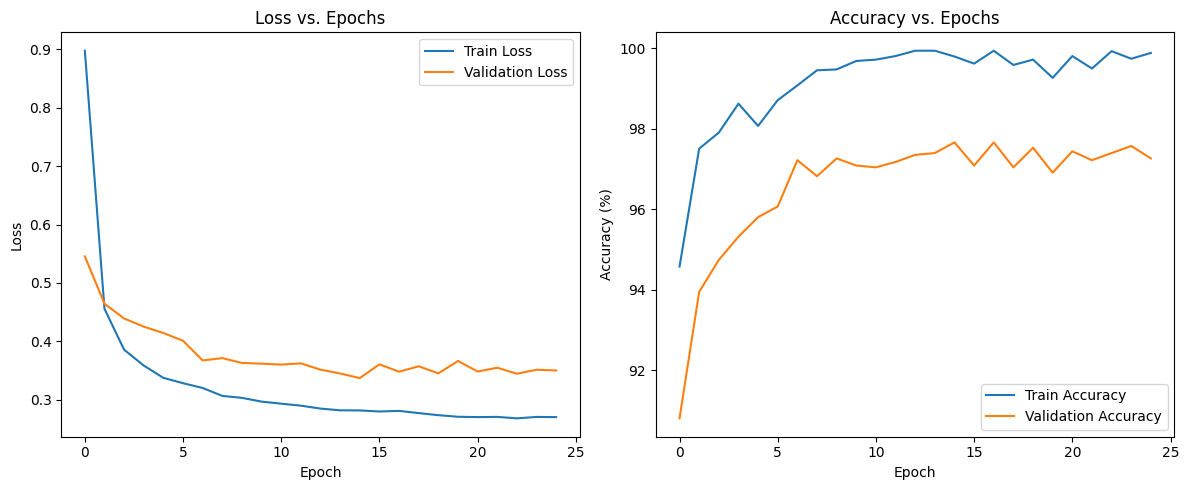

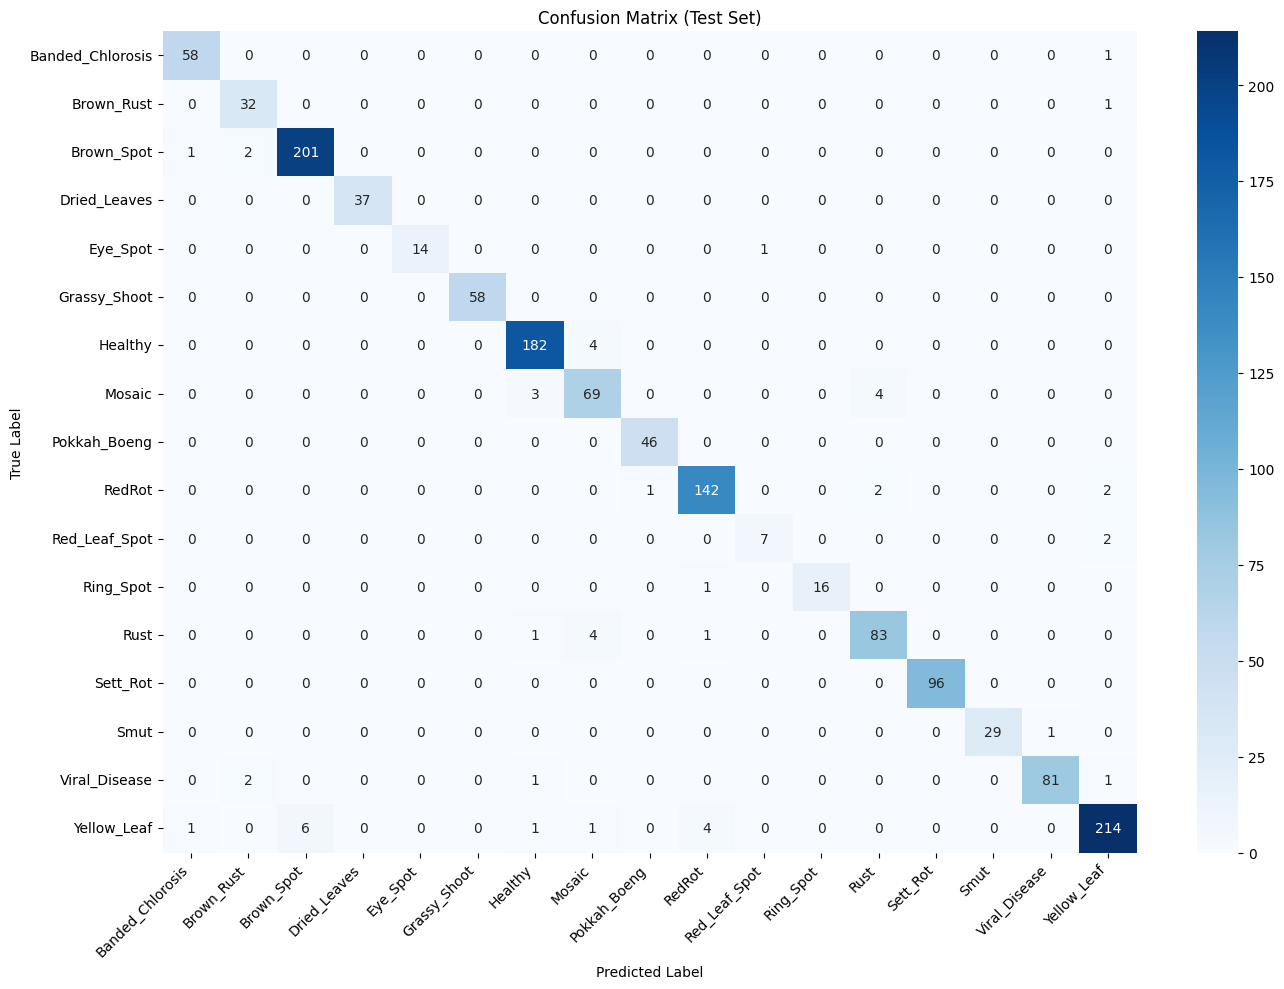

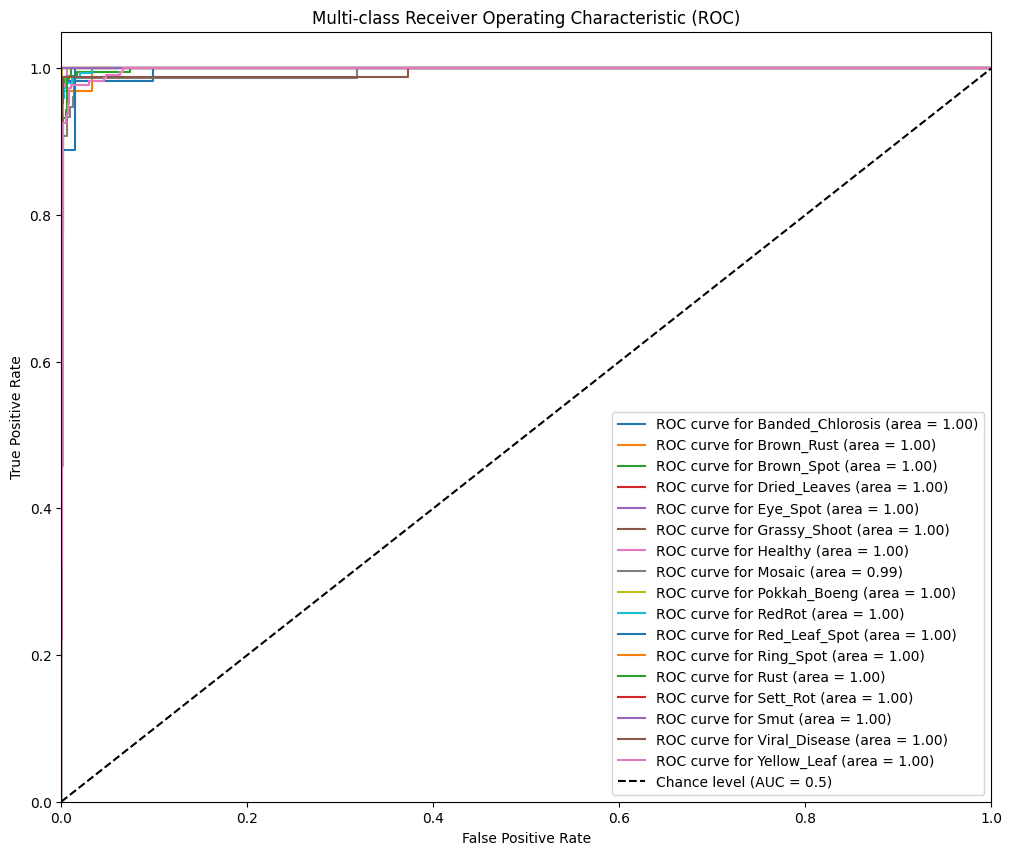

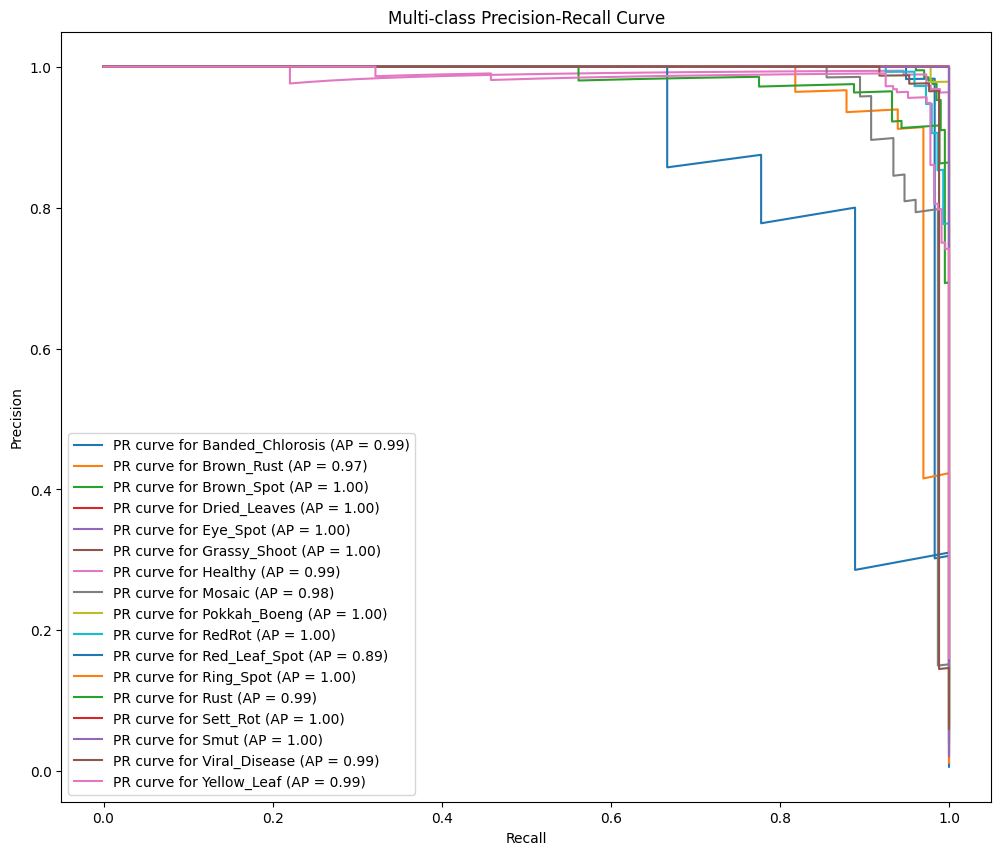

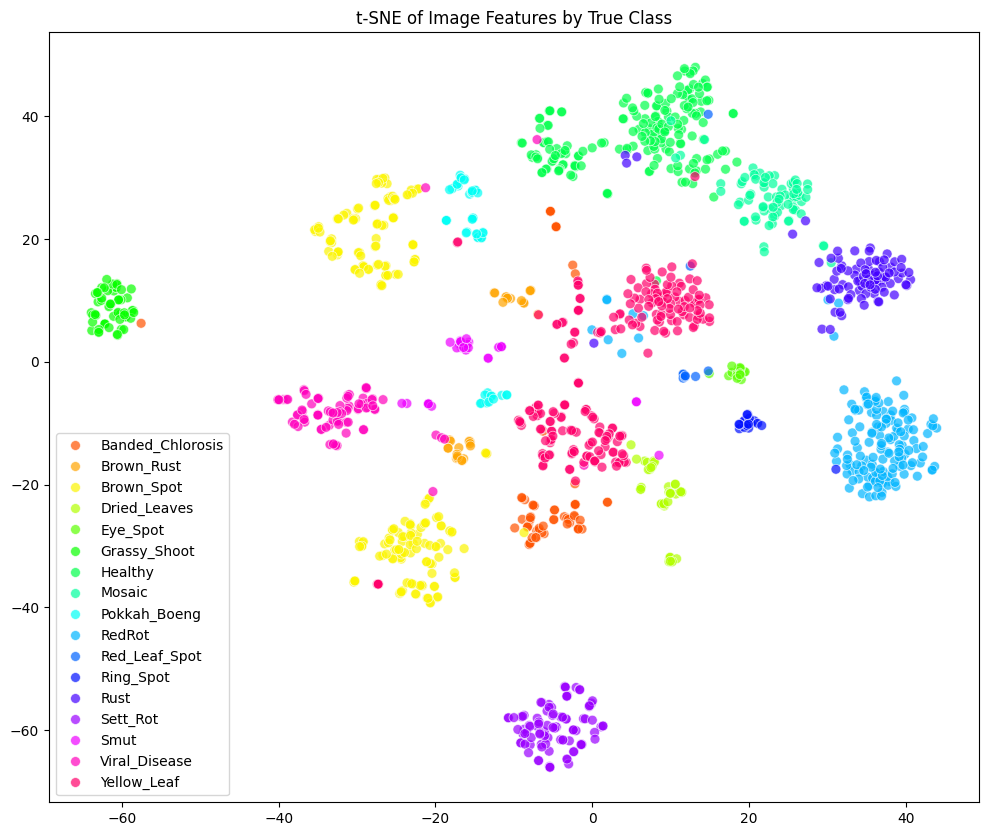

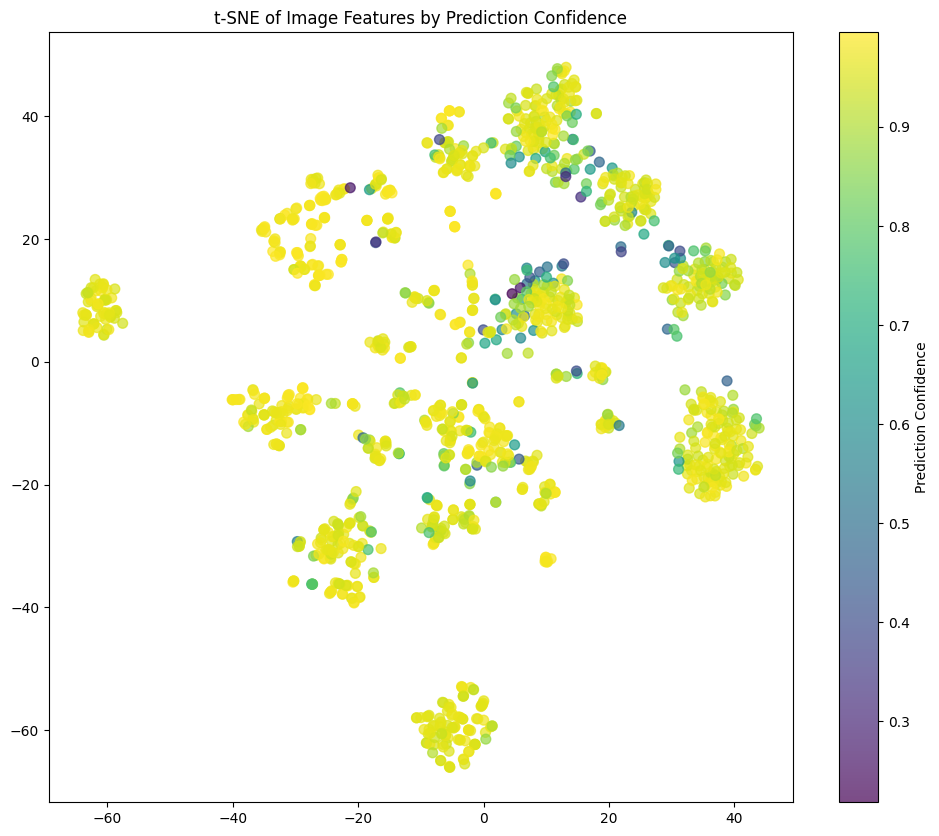

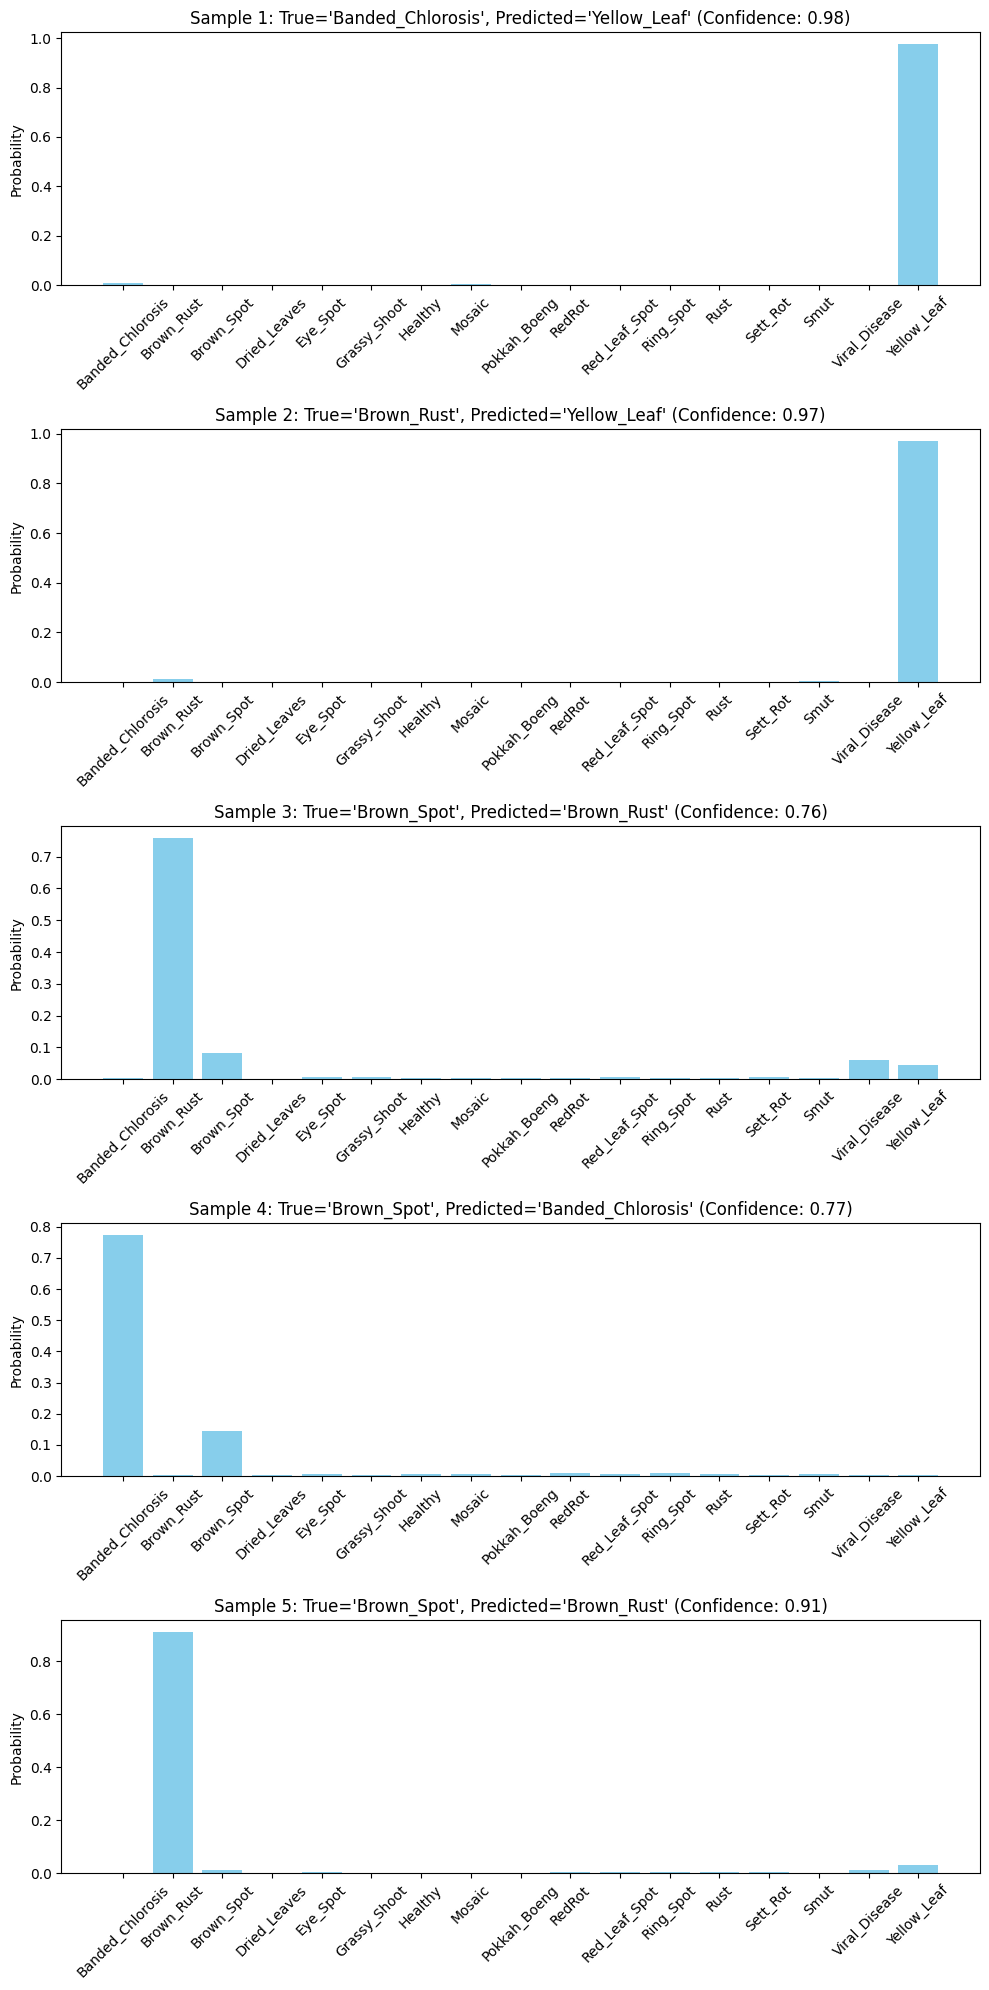

In [3]:
# a) Convergence Plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs'); plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.legend()
plt.tight_layout()
plt.savefig('./mobilenetv3_small_outputs/convergence_plots.png')
print("Saved convergence plots to ./mobilenetv3_small_outputs/convergence_plots.png")


    
# c) Confusion Matrix
plt.figure(figsize=(14, 10))
cm = confusion_matrix(test_targets, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names_report, yticklabels=class_names_report)
plt.title('Confusion Matrix (Test Set)'); plt.ylabel('True Label'); plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('./mobilenetv3_small_outputs/confusion_matrix.png')
print("Saved confusion matrix to ./mobilenetv3_small_outputs/confusion_matrix.png")

# Binarize labels for multi-class ROC/PR curves
y_true_bin = label_binarize(test_targets, classes=range(num_classes))

# d) ROC-AUC Curve
plt.figure(figsize=(12, 10))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_outputs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve for {class_names_report[i]} (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance level (AUC = 0.5)')
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('Multi-class Receiver Operating Characteristic (ROC)'); plt.legend(loc="lower right")
plt.savefig('./mobilenetv3_small_outputs/roc_auc_curve.png')
print("Saved ROC-AUC curve to ./mobilenetv3_small_outputs/roc_auc_curve.png")

# e) Precision-Recall Curve
plt.figure(figsize=(12, 10))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], test_outputs[:, i])
    avg_precision = average_precision_score(y_true_bin[:, i], test_outputs[:, i])
    plt.plot(recall, precision, label=f'PR curve for {class_names_report[i]} (AP = {avg_precision:.2f})')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Multi-class Precision-Recall Curve'); plt.legend(loc="best")
plt.savefig('./mobilenetv3_small_outputs/precision_recall_curve.png')
print("Saved Precision-Recall curve to ./mobilenetv3_small_outputs/precision_recall_curve.png")

# --- 8. t-SNE Visualization ---
def extract_features(model, loader, device):
    """
    Extracts deep features from the model for t-SNE visualization.
    """
    features = []
    labels = []
    model.eval()
    
    original_classifier = model.base_model.classifier
    model.base_model.classifier = nn.Identity()
    
    with torch.no_grad():
        for data, target in tqdm(loader, desc="Extracting features for t-SNE"):
            data = data.to(device)
            output = model(data)
            features.append(output.cpu().numpy())
            labels.append(target.numpy())
            
    model.base_model.classifier = original_classifier
    return np.concatenate(features), np.concatenate(labels)

print("\n--- Generating t-SNE visualizations ---")
features, tsne_labels = extract_features(best_model, test_loader, device)
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=min(30, len(features)-1), n_iter=1000, init='pca')
tsne_results = tsne.fit_transform(features)

# Get prediction confidence scores for the test set
confidences = np.max(test_outputs, axis=1)

# f) t-SNE plot colored by true labels
plt.figure(figsize=(12, 10))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=[class_names_report[l] for l in tsne_labels], palette=sns.color_palette("hsv", num_classes), s=50, alpha=0.7)
plt.title('t-SNE of Image Features by True Class'); plt.legend(loc='best')
plt.savefig('./mobilenetv3_small_outputs/tsne_by_class.png')
print("Saved t-SNE plot by class to ./mobilenetv3_small_outputs/tsne_by_class.png")

# g) t-SNE plot colored by confidence
plt.figure(figsize=(12, 10))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=confidences, cmap='viridis', s=50, alpha=0.7)
plt.colorbar(scatter, label='Prediction Confidence')
plt.title('t-SNE of Image Features by Prediction Confidence')
plt.savefig('./mobilenetv3_small_outputs/tsne_by_confidence.png')
print("Saved t-SNE plot by confidence to ./mobilenetv3_small_outputs/tsne_by_confidence.png")

# h) Confidence Bar Plots for Misclassified Images
misclassified_indices = np.where(np.array(test_preds) != np.array(test_targets))[0]
if len(misclassified_indices) > 0:
    print(f"\nFound {len(misclassified_indices)} misclassified images. Plotting confidence for a few examples.")
    num_to_plot = min(len(misclassified_indices), 5)
    fig, axes = plt.subplots(num_to_plot, 1, figsize=(10, num_to_plot * 4))
    if num_to_plot == 1: axes = [axes] # Make it iterable
    for i, idx in enumerate(misclassified_indices[:num_to_plot]):
        true_label = class_names_report[test_targets[idx]]
        pred_label = class_names_report[test_preds[idx]]
        probs = test_outputs[idx]
        
        axes[i].bar(class_names_report, probs, color='skyblue')
        axes[i].set_title(f"Sample {i+1}: True='{true_label}', Predicted='{pred_label}' (Confidence: {probs[test_preds[idx]]:.2f})")
        axes[i].set_ylabel("Probability")
        axes[i].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.savefig('./mobilenetv3_small_outputs/misclassified_confidence.png')
    print("Saved confidence plots for misclassified samples to ./mobilenetv3_small_outputs/misclassified_confidence.png")
else:
    print("\nNo misclassified images found in the test set. Perfect score!")

print("\nScript finished successfully. All artifacts are in the './mobilenetv3_small_outputs' directory.")